## `Course evaluation information`

- Concisely note down your observations for each lab from now on.
- You can take notes inside the notebooks, or in separate PDFs.
- Either way, be ready to show the work you putted into each lab, including the experiments and the learning outcomes.
- During the exam, you will be asked to show your notes for some of the labs at random with a brief discussion on its content

# Lab. 1: Local search

## Introduction

#### <u>The goal is to study the application of local search algorithms on different benchmark functions.</u>

We will see the following methods:
- *Grid Search*
- *Random Search*
- *Powell*
- *Nelder Mead*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or you can print it with *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [17]:
%%capture

try:
  import benchmark_functions as bf
except:
  !pip3 install benchmark_functions
  import benchmark_functions as bf

from scipy.optimize import minimize, rosen
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

plt.rcParams["figure.figsize"] = (8,5)


In [18]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        return self.f.minima()
    
    def get_minima(self):
        return self.f.minima()[0].score

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.xlabel('Iterations')
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()
        

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

def grid_search(f: OptFun, step_size=None, number_of_steps=None):
    """
    Optimizes a function by using the grid_search algorithm.

    - f: function to optimize, an instance of OptFun
    - step_size: the step size
    - number_of_steps: the total number of steps
    """
    bounds = f.bounds()
    if (step_size != None):
        for x in np.arange(bounds[0][0], bounds[0][1], step_size):
            for y in np.arange(bounds[1][0], bounds[1][1], step_size):
                func([x, y])
    elif (number_of_steps != None):
        for x in np.linspace(bounds[0][0], bounds[0][1], int(np.floor(np.sqrt(number_of_steps)))):
            for y in np.linspace(bounds[1][0], bounds[1][1], int(np.floor(np.sqrt(number_of_steps)))):
                func([x, y])
    else:
        print("Please provide at least the step_size or the")

def random_search(f: OptFun, n_samples_drawn):
    """
    Optimizes a function by using the random_search algorithm.

    - f: function to optimize, an instance of OptFun
    - number_of_steps: the total number of steps
    """
    bounds = f.bounds()
    for i in range(n_samples_drawn):
        x = np.random.uniform(bounds[0][0], bounds[0][1])
        y = np.random.uniform(bounds[1][0], bounds[1][1])
        func([x, y])

def powell(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Powell algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    results = minimize(fun=f, x0=list(x0), method="powell", bounds=bounds,
                       options={"ftol":1e-4,
                                "maxfev": None,
                                "maxiter": maxiter,
                                "return_all":True})
    return results

def nelder_mead(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Nelder-Mead algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    return minimize(
        f,
        x0,
        method='Nelder-Mead',
        tol=None,
        bounds=bounds,
        options={
            "maxfev": None,
            "maxiter": maxiter,
            'disp': False,
            'return_all': True,
            'initial_simplex': None,
            'xatol': 0.000,
            'fatol': 0.000,
            'adaptive': False
        }
    )

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?
- The choiche of the parameters is influenced by the function to optimize? And how the algorithms are influenced by the parameters?

## Exercise 1/4: GRID SEARCH
In this first exercise we will use grid search as a search algorithm

### Questions
- How does the step size influence the quality of the best point obtained?
- How does the step size influence the search cost?

4.440892098500626e-16


<Figure size 800x500 with 0 Axes>

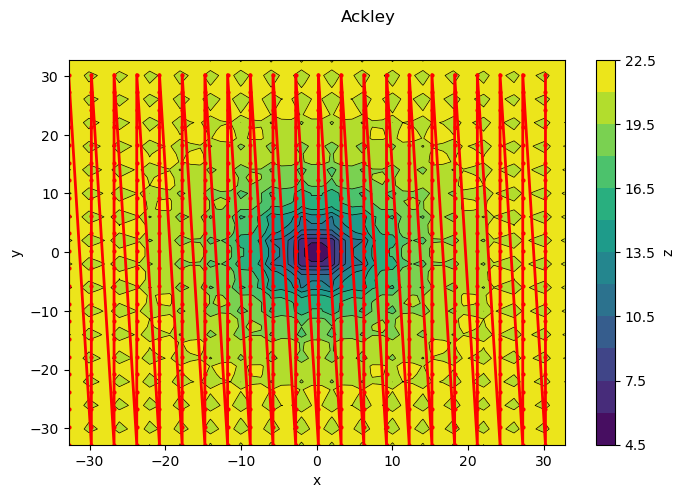

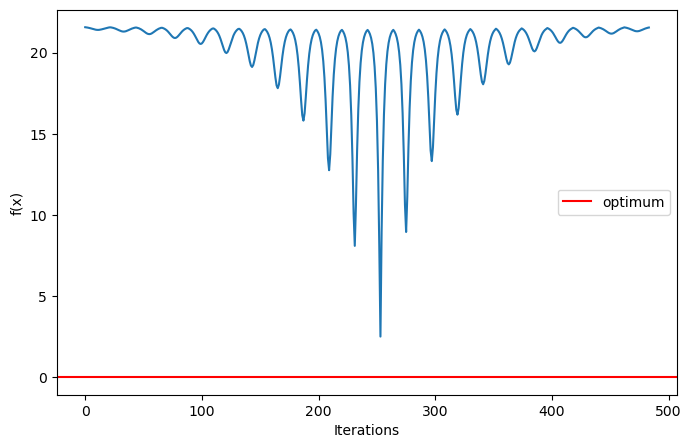

In [67]:
# TODO: try differenct benchmark functions
func = OptFun(bf.Ackley(2))
step_size = 3  # TODO: try different step_size values (e.g.: [0.5, 1, 3])

grid_search(func, step_size=step_size)

values = [func.f(v) for v in func.history]
print(func.get_minima())


func.heatmap()
func.plot()


## Exercise 2/4: RANDOM SEARCH

In this exercise we will use Random Search to search for the optimum

### Questions
- How does the number of samples drawn affect the search?
- How does this method compare to Grid Search? What are the advantages and disadvantages?

0.0


<Figure size 800x500 with 0 Axes>

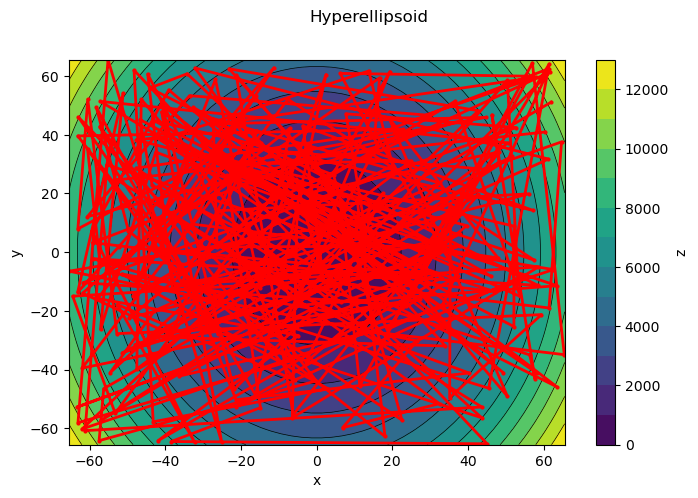

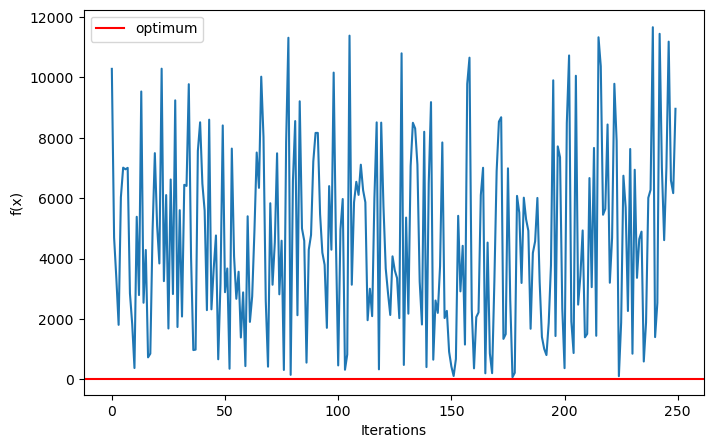

In [72]:
func = OptFun(bf.Hyperellipsoid(2))  # TODO: try differenct benchmark functions
bounds = func.bounds()
n_samples_drawn = 250  # TODO: try different values (e.g.: [3, 30, 50])

random_search(func, n_samples_drawn)

print(func.get_minima())

func.heatmap()
func.plot()

## Exercise 3/4: POWELL OPTIMIZATION

In this exercise we will focus on the Powel optimization algorithm.

### Questions
- What happens when varying the parameters of the algorithm?
- How they influence the optimization process?
- The effects of these parameters is the same across different functions?
- How does this algorithm compare to the previous?

In [22]:
# list of functions
print(dir(bf))

['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']


0.0


<Figure size 800x500 with 0 Axes>

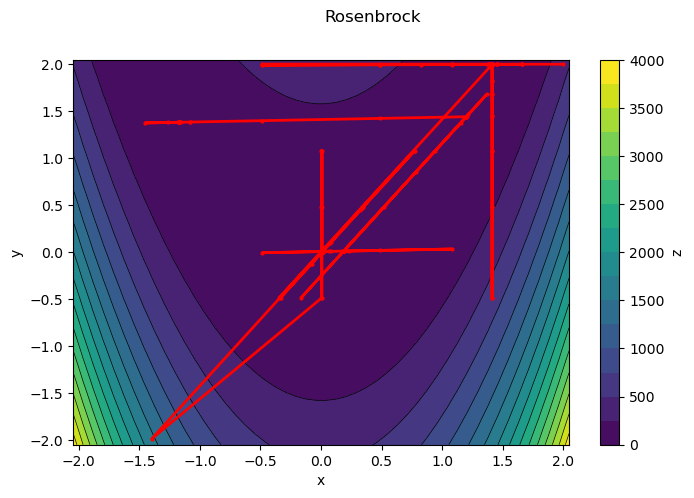

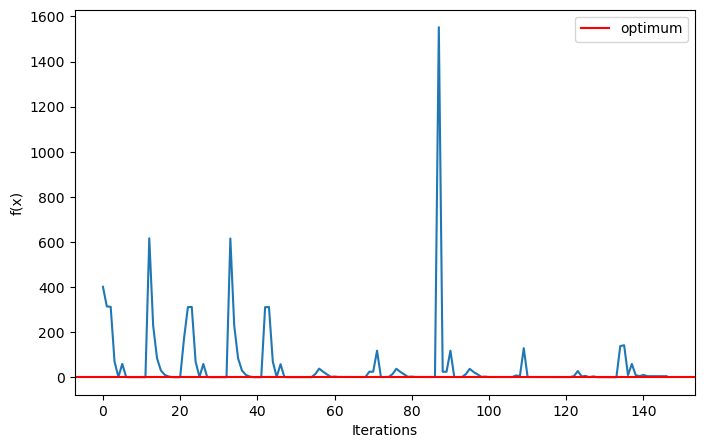

In [79]:
func = OptFun(bf.Michalewicz(2))    # TODO: try differenct benchmark functions and parameters
x_0 = [1., -1]  # TODO: try other suitable initial points
max_iter = 1  # TODO: try other values

powell(func, x_0, max_iter)

print(func.get_minima())
func.heatmap()
func.plot()

## Exercise 4/4: NELDER MEAD OPTIMIZATION

In this exercise we will focus on the Nelder Mead optimization algorithm.
Similar to the previous exercise, answer the following questions:

### Questions
- What happens when varying the parameters of the algorithm?
- How they influence the optimization process?
- The effects of these parameters is the same across different functions?
- How does this algorithm compare to the previous?

<Figure size 800x500 with 0 Axes>

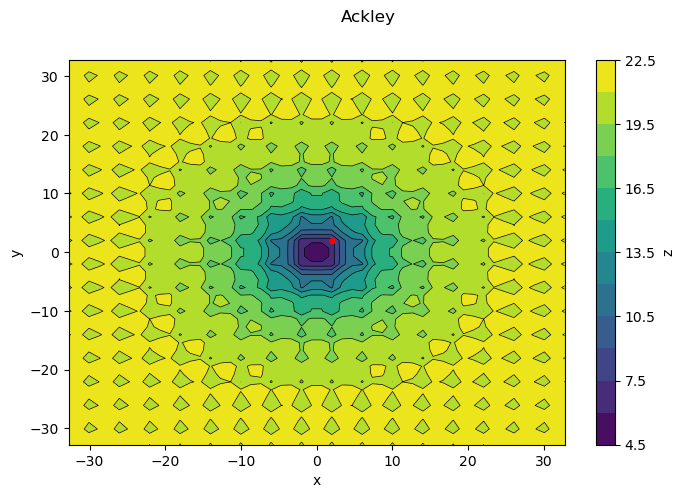

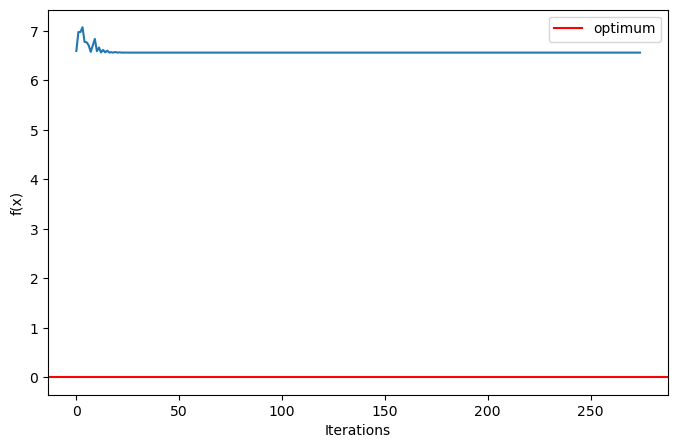

In [117]:
func = OptFun(bf.Ackley (2))  # TODO: try differenct benchmark functions and parameters
x_0 = [2., 2.]  # TODO: try other suitable initial points
max_iter = 100  # TODO: try other values

nelder_mead(func, x_0, max_iter)

func.heatmap()
func.plot()

# with 3 3 need around 40 iterations 

In [25]:
import numpy as np
from scipy.optimize import minimize

# Define the benchmark functions
def ackley(x):
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2))) \
           - np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1]))) + np.exp(1) + 20

def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rosenbrock(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def sphere(x):
    return np.sum(x**2)

# Set initial guesses
x0 = np.array([2.0, 2.0])  # Initial guess

# Set maximum iterations
max_iter = 100  # Maximum iterations

# Optimization with default parameters
result_default_ackley = minimize(ackley, x0, method='nelder-mead', options={'maxiter': max_iter})
result_default_rastrigin = minimize(rastrigin, x0, method='nelder-mead', options={'maxiter': max_iter})
result_default_rosenbrock = minimize(rosenbrock, x0, method='nelder-mead', options={'maxiter': max_iter})
result_default_sphere = minimize(sphere, x0, method='nelder-mead', options={'maxiter': max_iter})

# Print results
print("Default Parameters:")
print("Ackley:", result_default_ackley.x, result_default_ackley.fun)
print("Rastrigin:", result_default_rastrigin.x, result_default_rastrigin.fun)
print("Rosenbrock:", result_default_rosenbrock.x, result_default_rosenbrock.fun)
print("Sphere:", result_default_sphere.x, result_default_sphere.fun)

# Adjusting initial guess
x0_new = np.array([5.0, 5.0])  # New initial guess

# Optimization with new initial guess
result_new_ackley = minimize(ackley, x0_new, method='nelder-mead', options={'maxiter': max_iter})
result_new_rastrigin = minimize(rastrigin, x0_new, method='nelder-mead', options={'maxiter': max_iter})
result_new_rosenbrock = minimize(rosenbrock, x0_new, method='nelder-mead', options={'maxiter': max_iter})
result_new_sphere = minimize(sphere, x0_new, method='nelder-mead', options={'maxiter': max_iter})

# Print results with new initial guess
print("\nAdjusted Initial Guess (x0=[5.0, 5.0]):")
print("Ackley:", result_new_ackley.x, result_new_ackley.fun)
print("Rastrigin:", result_new_rastrigin.x, result_new_rastrigin.fun)
print("Rosenbrock:", result_new_rosenbrock.x, result_new_rosenbrock.fun)
print("Sphere:", result_new_sphere.x, result_new_sphere.fun)

# Adjusting maximum iterations
max_iter_new = 200  # New maximum iterations

# Optimization with new maximum iterations
result_iter_ackley = minimize(ackley, x0, method='nelder-mead', options={'maxiter': max_iter_new})
result_iter_rastrigin = minimize(rastrigin, x0, method='nelder-mead', options={'maxiter': max_iter_new})
result_iter_rosenbrock = minimize(rosenbrock, x0, method='nelder-mead', options={'maxiter': max_iter_new})
result_iter_sphere = minimize(sphere, x0, method='nelder-mead', options={'maxiter': max_iter_new})

# Print results with new maximum iterations
print("\nAdjusted Maximum Iterations (max_iter=200):")
print("Ackley:", result_iter_ackley.x, result_iter_ackley.fun)
print("Rastrigin:", result_iter_rastrigin.x, result_iter_rastrigin.fun)
print("Rosenbrock:", result_iter_rosenbrock.x, result_iter_rosenbrock.fun)
print("Sphere:", result_iter_sphere.x, result_iter_sphere.fun)


Default Parameters:
Ackley: [1.97442506 1.97445789] 6.559645395501416
Rastrigin: [1.98993827 1.98988988] 7.959662614219198
Rosenbrock: [0.99998292 0.99996512] 3.4239552925089766e-10
Sphere: [-4.13302749e-05 -1.01526896e-05] 1.8112687307246913e-09

Adjusted Initial Guess (x0=[5.0, 5.0]):
Ackley: [4.98619291 4.98622749] 12.63226905409916
Rastrigin: [4.97467821 4.97465616] 49.74744614625404
Rosenbrock: [0.99994419 0.99989869] 1.376260947815959e-08
Sphere: [-3.33051318e-05 -1.93825710e-05] 1.4849158640215086e-09

Adjusted Maximum Iterations (max_iter=200):
Ackley: [1.97442506 1.97445789] 6.559645395501416
Rastrigin: [1.98993827 1.98988988] 7.959662614219198
Rosenbrock: [0.99998292 0.99996512] 3.4239552925089766e-10
Sphere: [-4.13302749e-05 -1.01526896e-05] 1.8112687307246913e-09


In [26]:
import numpy as np
from scipy.optimize import minimize

# Define the benchmark functions
def ackley(x):
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2))) \
           - np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1]))) + np.exp(1) + 20

def rastrigin(x):
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rosenbrock(x):
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def sphere(x):
    return np.sum(x**2)

# Set initial guesses
x0 = np.array([2.0, 2.0])  # Initial guess

# Set maximum iterations
max_iter = 100  # Maximum iterations

# Optimization with default parameters using Powell method
result_default_ackley = minimize(ackley, x0, method='powell', options={'maxiter': max_iter})
result_default_rastrigin = minimize(rastrigin, x0, method='powell', options={'maxiter': max_iter})
result_default_rosenbrock = minimize(rosenbrock, x0, method='powell', options={'maxiter': max_iter})
result_default_sphere = minimize(sphere, x0, method='powell', options={'maxiter': max_iter})

# Print results
print("Default Parameters:")
print("Ackley:", result_default_ackley.x, result_default_ackley.fun)
print("Rastrigin:", result_default_rastrigin.x, result_default_rastrigin.fun)
print("Rosenbrock:", result_default_rosenbrock.x, result_default_rosenbrock.fun)
print("Sphere:", result_default_sphere.x, result_default_sphere.fun)

# Adjusting initial guess
x0_new = np.array([5.0, 5.0])  # New initial guess

# Optimization with new initial guess using Powell method
result_new_ackley = minimize(ackley, x0_new, method='powell', options={'maxiter': max_iter})
result_new_rastrigin = minimize(rastrigin, x0_new, method='powell', options={'maxiter': max_iter})
result_new_rosenbrock = minimize(rosenbrock, x0_new, method='powell', options={'maxiter': max_iter})
result_new_sphere = minimize(sphere, x0_new, method='powell', options={'maxiter': max_iter})

# Print results with new initial guess
print("\nAdjusted Initial Guess (x0=[5.0, 5.0]):")
print("Ackley:", result_new_ackley.x, result_new_ackley.fun)
print("Rastrigin:", result_new_rastrigin.x, result_new_rastrigin.fun)
print("Rosenbrock:", result_new_rosenbrock.x, result_new_rosenbrock.fun)
print("Sphere:", result_new_sphere.x, result_new_sphere.fun)

# Adjusting maximum iterations
max_iter_new = 200  # New maximum iterations

# Optimization with new maximum iterations using Powell method
result_iter_ackley = minimize(ackley, x0, method='powell', options={'maxiter': max_iter_new})
result_iter_rastrigin = minimize(rastrigin, x0, method='powell', options={'maxiter': max_iter_new})
result_iter_rosenbrock = minimize(rosenbrock, x0, method='powell', options={'maxiter': max_iter_new})
result_iter_sphere = minimize(sphere, x0, method='powell', options={'maxiter': max_iter_new})

# Print results with new maximum iterations
print("\nAdjusted Maximum Iterations (max_iter=200):")
print("Ackley:", result_iter_ackley.x, result_iter_ackley.fun)
print("Rastrigin:", result_iter_rastrigin.x, result_iter_rastrigin.fun)
print("Rosenbrock:", result_iter_rosenbrock.x, result_iter_rosenbrock.fun)
print("Sphere:", result_iter_sphere.x, result_iter_sphere.fun)


Default Parameters:
Ackley: [-1.08089481e-12 -1.04347432e-12] 4.249045559845399e-12
Rastrigin: [1.98991223 1.98991223] 7.959662381108176
Rosenbrock: [1. 1.] 7.346267179870672e-30
Sphere: [0. 0.] 0.0

Adjusted Initial Guess (x0=[5.0, 5.0]):
Ackley: [4.98618035 4.98618045] 12.63226899151629
Rastrigin: [4.97469134 4.97469134] 49.7474458690856
Rosenbrock: [1. 1.] 3.840273494229038e-28
Sphere: [7.10542736e-15 1.77635684e-15] 5.36425415550288e-29

Adjusted Maximum Iterations (max_iter=200):
Ackley: [-1.08089481e-12 -1.04347432e-12] 4.249045559845399e-12
Rastrigin: [1.98991223 1.98991223] 7.959662381108176
Rosenbrock: [1. 1.] 7.346267179870672e-30
Sphere: [0. 0.] 0.0


## Final questions
- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?
- The choiche of the parameters is influenced by the function to optimize? And how the algorithm are influenced by the parameters?

In [27]:
# TODO: compare the different optimization algorithms

----

Optimizing using Rastrigin function:
0.0


<Figure size 800x500 with 0 Axes>

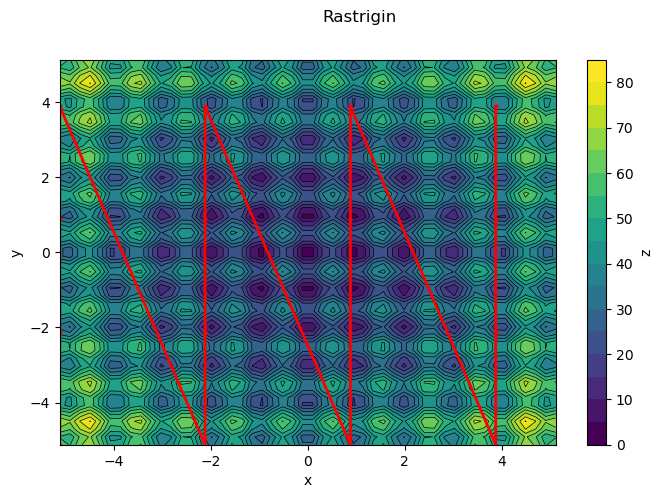

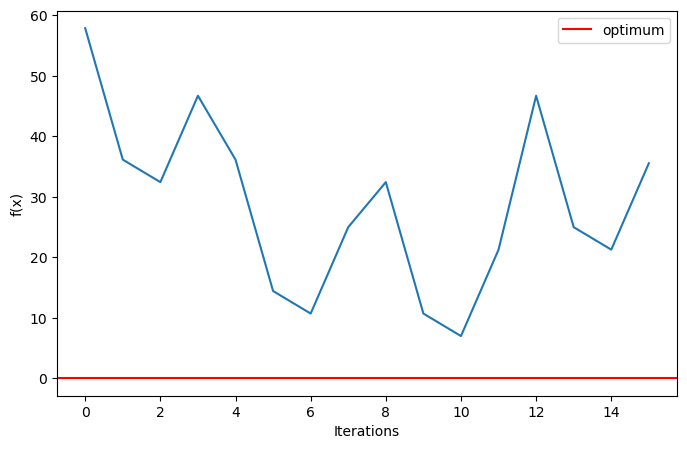

Optimizing using Griewank function:
0.0


<Figure size 800x500 with 0 Axes>

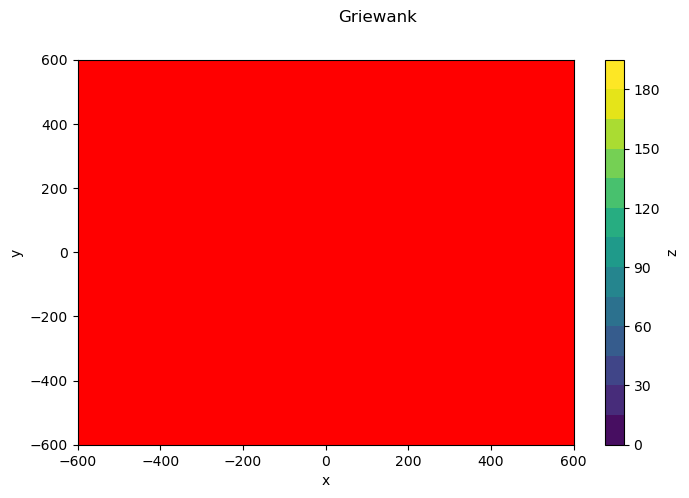

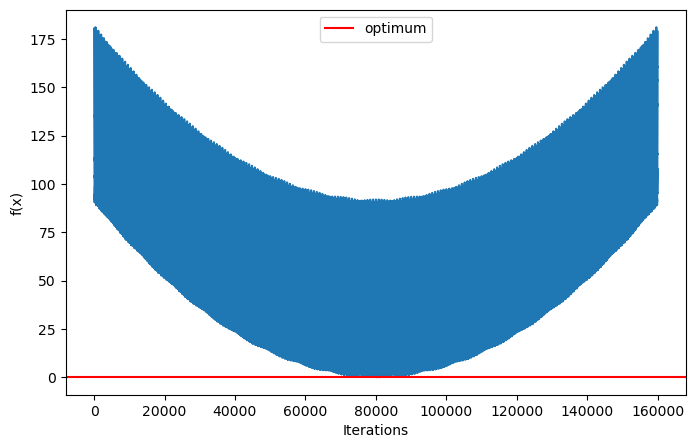

In [28]:
# COMPARISIONS

import benchmark_functions as bf

# Define a list of benchmark functions
benchmark_functions = {
    #'Sphere': bf.Sphere,
    'Rastrigin': bf.Rastrigin,
    'Griewank': bf.Griewank,
    # Add more benchmark functions here as needed
}

# Iterate through each benchmark function
for func_name, benchmark_func in benchmark_functions.items():
    print(f"Optimizing using {func_name} function:")
    func = OptFun(benchmark_func(2))  # Assuming all functions have 2 dimensions
    step_size = 3  # You can try different step sizes here

    grid_search(func, step_size=step_size)

    print(func.get_minima())

    func.heatmap()
    func.plot()
